<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/modeling_LeNet/test_sample_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q wget datasets fire transformers

In [1]:
! rm -rf PyTorch-Architectures/
! git clone https://github.com/vishal-burman/PyTorch-Architectures.git

Cloning into 'PyTorch-Architectures'...
remote: Enumerating objects: 4890, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 4890 (delta 135), reused 105 (delta 84), pack-reused 4716
Receiving objects: 100% (4890/4890), 11.15 MiB | 6.10 MiB/s, done.
Resolving deltas: 100% (2872/2872), done.


In [2]:
%cd PyTorch-Architectures/

/content/PyTorch-Architectures


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from modeling_LeNet import LeNet
from toolkit.custom_dataset_cv import DataLoaderCIFAR10Classification
from toolkit.utils import dict_to_device
from toolkit import Trainer

In [4]:
# Unit test the model
! python -m unittest modeling_LeNet/test_model.py

..
----------------------------------------------------------------------
Ran 2 tests in 0.016s

OK


In [5]:
# Hyperparameters
INPUT_SIZE = 32
BATCH_SIZE = 512
LEARNING_RATE = 0.001
EPOCHS = 3

In [6]:
train_loader = DataLoaderCIFAR10Classification(resize=INPUT_SIZE, 
                                               train=True,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

valid_loader = DataLoaderCIFAR10Classification(resize=INPUT_SIZE, 
                                               train=False,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False)

print(f"Length of Train Loader --> {len(train_loader)}")
print(f"Length of Valid Loader --> {len(valid_loader)}")

cifar10 extracted...
cifar10 exists...
Length of Train Loader --> 98
Length of Valid Loader --> 20


In [7]:
# Sanity check DataLoader
for sample in train_loader:
  assert sample["pixel_values"].dim() == 4
  assert sample["pixel_values"].size(2) == INPUT_SIZE
  break

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeNet(num_classes=10)
model.to(device)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters --> {params}")

Trainable Parameters --> 548878


In [9]:
# Sanity check forward pass
model.eval()
with torch.set_grad_enabled(False):
  for sample in train_loader:
    loss, logits = model(**dict_to_device(sample, device=device))
    print(f"Loss --> {loss.item(): .2f}")
    print(f"Logits Shape --> {logits.shape}")
    break

Loss -->  2.30
Logits Shape --> torch.Size([512, 10])


In [10]:
trainer = Trainer(model=model,
                  train_dataset=train_loader,
                  valid_dataset=valid_loader,
                  optimizer="adam",
                  scheduler=None,
                  lr=LEARNING_RATE,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  eval_metric="cv_accuracy",
                  show_grad_flow=True
                  )

********** Running Training **********
  Total Training Steps = 294  
  Epochs = 3  
  Batch Size = 512  
  Length of Train DataLoader = 98  
  Length of Valid DataLoader = 20  


  0%|          | 0/294 [00:00<?, ?it/s]


Epoch: 1 || Training Loss: 1.608 || cv_accuracy: 51.720

Gradient-Flow for epoch 1


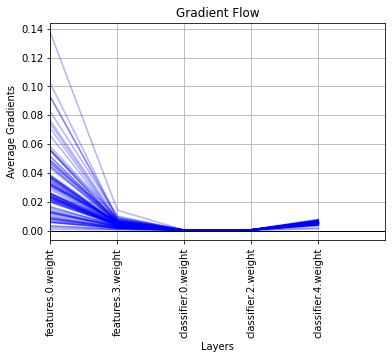


Epoch: 2 || Training Loss: 1.279 || cv_accuracy: 55.690

Gradient-Flow for epoch 2


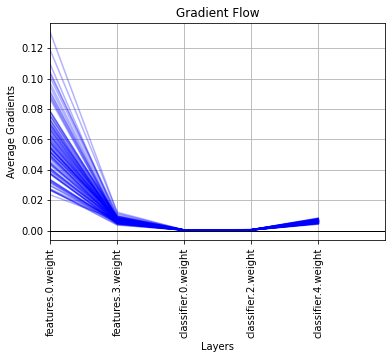


Epoch: 3 || Training Loss: 1.137 || cv_accuracy: 61.130

Gradient-Flow for epoch 3


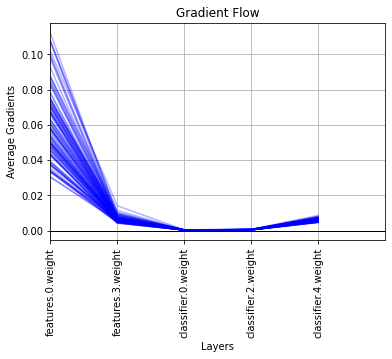

In [11]:
trainer.train()